# 1. Basic Operations
In this notebook, we'll explore different basic operations, such as convolution and pooling, common to all deep neural networks.
First, we import all necessary packages.

In [2]:
import numpy as np

import torch

import cv2
import skimage
from matplotlib import pyplot as plt

import requests
from io import BytesIO

## Input image

Reading an image from URL.
One can pass the path of a local image to ```skimage.io.imread``` function as well.

```skimage``` (scikit-image) is a collection of algorithms for image processing.

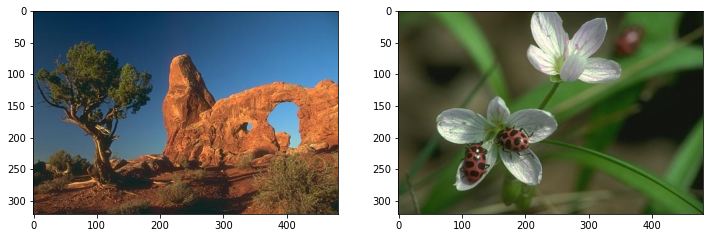

In [2]:
urls = [
    'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/295087.jpg',
    'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/35008.jpg'
]


# we use list comprehensions to quickly load images
imgs = [skimage.io.imread(BytesIO(requests.get(url).content)) for url in urls]

# visualising both images we loaded
fig = plt.figure(figsize=(12, 4))
for img_ind, img in enumerate(imgs):
    ax = fig.add_subplot(1, 2, img_ind + 1)
    ax.imshow(img)

An RGB image has the size ```(w, h, 3)```, the third dimension corresponds to RGB (colour) channels). A grey-scale image has the size ```(w, h)```.

In [3]:
print("Image size:", imgs[0].shape)
print("Image type:", imgs[0].dtype)

Image size: (481, 3)
Image type: uint8


Plotting each RGB channel separately. We define a function so we can call it for each image easiliy.

We use the ```pyplot``` (plt) to create a figure and add three subplots to it.

In [4]:
def plot_3channels(img):
    channel_names = ['Red', 'Green', 'Blue']
    fig = plt.figure(figsize=(16, 4))
    for i in range(img.shape[2]):
        ax = fig.add_subplot(1, 3, i+1)
        ax.imshow(img[..., i], cmap='gray')
        ax.axis('off')
        ax.set_title(channel_names[i])

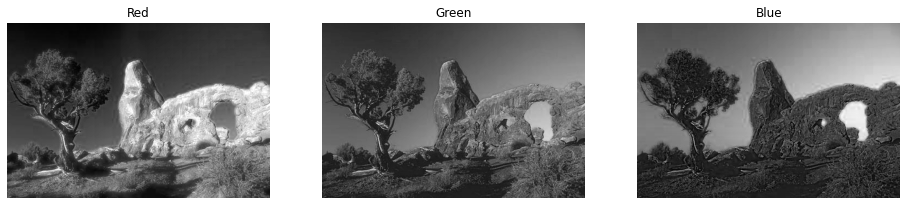

In [5]:
plot_3channels(imgs[0])

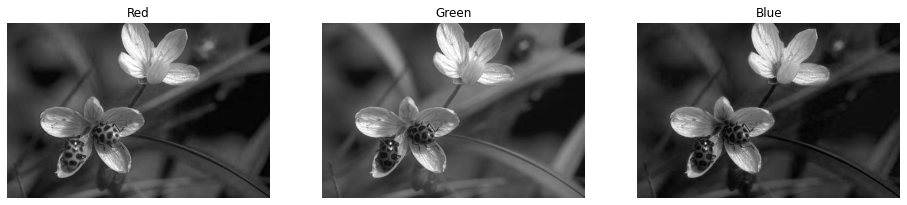

In [6]:
plot_3channels(imgs[1])

## Tensor
In this tutorial we'll use ```torch``` as one of the franeworks that supports basic operations.

```torch``` expects images in a different format, the type should be ```float``` and channels should proceed the spatial dimension, i.e., ```(3, w, h)```.

Furthermore, ```torch``` functions are designed for Tensors of 4D, where the first dimension corresponds to different images ```(b, 3, w, h)```. In our example b equals 2 as we have loaded two images.

In [7]:
# converting the images from uint8 to float and create a torch tensor
torch_tensors = [torch.from_numpy(img.astype('float32')) / 255 for img in imgs]
# permuting the tensor to place the RGB channles as the first dimension
torch_tensors = [torch.permute(torch_tensor, (2, 0, 1)) for torch_tensor in torch_tensors]
# stacking both images into one 4D tensor
torch_tensors = torch.stack(torch_tensors, dim=0)
print("Tensor size:", torch_tensors.shape)

Tensor size: torch.Size([2, 3, 321, 481])


## Convolution
We'll check different implementations for the convolution.

### Open-CV
We use the ```filter2D``` function of the opencv (```cv2```) that implements the convolution.

#### Edge detection
First we design a simple edge kernel sensitive to vertical edges.

In [8]:
edge_kernel = np.array(
    [
        [1, 0, -1],
        [1, 0, -1],
        [1, 0, -1],
    ]
)
print(edge_kernel)

[[ 1  0 -1]
 [ 1  0 -1]
 [ 1  0 -1]]


In [9]:
edge_imgs = [cv2.filter2D(img.copy(), ddepth=-1, kernel=edge_kernel) for img in imgs]

Showing the obtained edges. The output might appear visually distorted becasuse the edges in all RGB channels might not coincide.

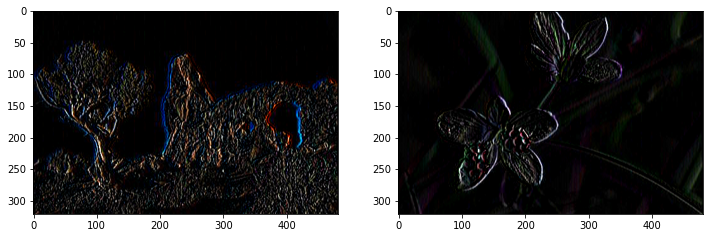

In [10]:
# visualising both images we loaded
fig = plt.figure(figsize=(12, 4))
for img_ind, img in enumerate(edge_imgs):
    ax = fig.add_subplot(1, 2, img_ind + 1)
    ax.imshow(img)

We can show the edges at each channel separately.

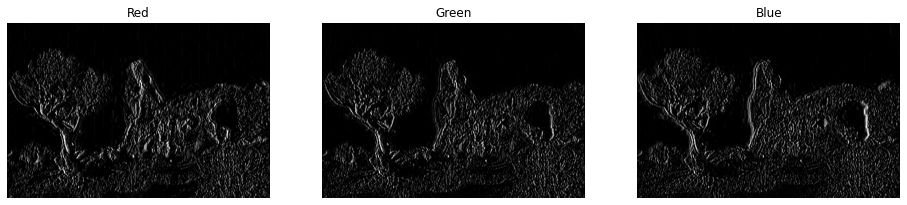

In [11]:
plot_3channels(edge_imgs[0])

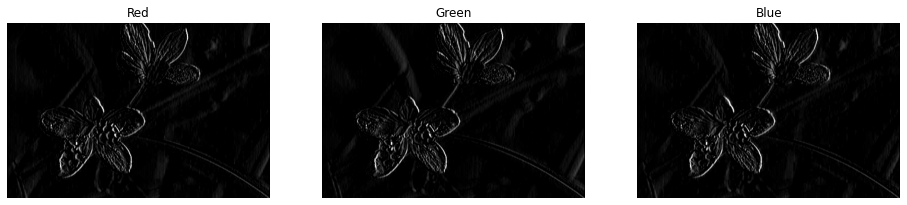

In [12]:
plot_3channels(edge_imgs[1])

**Question**: play with different kernel sizes (instead of current 3x3), what is the effect of larger kernel size?

#### Image blurring
We define a kernel whose output is the average of the window.

In [13]:
kernel_size = 5
avg_kernel = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)
print(avg_kernel)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


In [14]:
blurred_imgs = [cv2.filter2D(img.copy(), ddepth=-1, kernel=avg_kernel) for img in imgs]

Showing the blurred images.

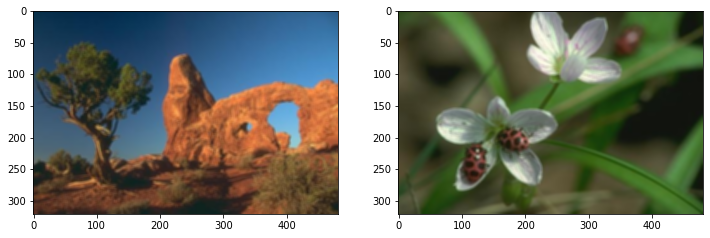

In [15]:
# visualising both images we loaded
fig = plt.figure(figsize=(12, 4))
for img_ind, img in enumerate(blurred_imgs):
    ax = fig.add_subplot(1, 2, img_ind + 1)
    ax.imshow(img)

### PyTorch
Now we check similar operations in ```torch```. Note, torch functions are designed to be integrated into a network, but for we use them here on single images to learn better basic operations.

#### Edge detection

We use ```torch.nn.Conv2d``` function to convolve a tensor with a kernel. Please note at this stage we only have defined the convoluton function that we call a few lined below.

We set ```requires_grad``` to ```False``` as we don't want to update the parameters.

After printing the ```weights``` of the kernel, we see that they are from a random distribution.

```torch_conv.weight.shape``` returns a 4D shape, (1, 3, 3, 3) corresponding to (out_channels, in_channels, kernel_size, kernel_size).

In [16]:
torch_conv = torch.nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(3, 3), bias=False)
torch_conv.weight.requires_grad = False
print(torch_conv.weight)
print(torch_conv.weight.shape)

Parameter containing:
tensor([[[[ 0.0328, -0.0133, -0.0254],
          [ 0.1297,  0.1521,  0.0434],
          [-0.0979, -0.1316,  0.0315]],

         [[ 0.0675,  0.1457,  0.1762],
          [ 0.1196,  0.1220,  0.1605],
          [ 0.1153,  0.1224, -0.1157]],

         [[ 0.0583,  0.1224, -0.1108],
          [ 0.1153,  0.1674,  0.0534],
          [ 0.1229,  0.1017, -0.1408]]]])
torch.Size([1, 3, 3, 3])


We fill in the weights with the edge kernel we defined earlier.

In [17]:
torch_conv.weight[0] = torch.from_numpy(np.stack([edge_kernel] * 3))
print(torch_conv.weight)

Parameter containing:
tensor([[[[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]],

         [[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]],

         [[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]]]])


We call the ```torch_conv``` function we defined to obtain edges in torch.

The output size is ```(2, 1, W, H)```, 2 corresponds to two images.

In [18]:
torch_edges = torch_conv(torch_tensors)
print(torch_edges.shape)

torch.Size([2, 1, 319, 479])


Converting the torch outputs to numpy for visualisation.

**Question** why does the results look quite different from what we obtained from open-cv?

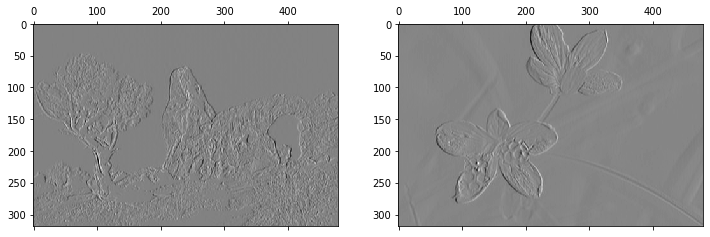

In [19]:
torch_edges_np = torch_edges.numpy()
torch_edges_np = np.transpose(torch_edges_np, (0, 2, 3, 1))

# visualising both images we loaded
fig = plt.figure(figsize=(12, 4))
for img_ind, img in enumerate(torch_edges_np):
    ax = fig.add_subplot(1, 2, img_ind + 1)
    ax.matshow(img, cmap='gray')

## Exercises

Below are a list of exercises helping you to practive what we learnt above.

### Pooling
 1. Process an image with max-ppoling in PyTorch, try different kernel-sizes (e.g., 3x3, 7x7, 15x15, etc.). Plot the outputs.
 2. Do the same with avg-pooling.
 3. Reflect on differences between avg and max pooling as a function of kernel size.

### Activation function
 1. Process the output of edge detection convolution in PyTorch with an activation function (e.g., ReLU or Sigmoid). Plot the outputs.
 2. Reflect on which activation function might be better for the edge-detection problem.